거래량 급등 종목 분석(python 3.x)
1. 구글 파이낸스에서 주가 데이터를 읽는다(코스피)
2. 거래량 상승 순으로 정렬
3. 결과출력 : 상승종목, 주가차트, 종목뉴스

In [1]:
# 라이브러리 
import pandas as pd
from pandas_datareader import data, wb
import pandas_datareader.data as web

import numpy as np

from datetime import datetime, timedelta
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')
matplotlib.rc('font', family='Malgun Gothic')  # 차트에 한글 사용
import seaborn as sns

from lxml import html, cssselect
import requests

In [57]:
### 캔들차트 소스 : 읽지 말고 넘어가기~! 
# 출처 : https://www.quantopian.com/posts/plot-candlestick-charts-in-research
def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'b'        
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)

In [3]:
# 코스피 종목코드 읽기
kospi = pd.read_csv('C:\\Users\\user\kospi_20170502.crm', sep='\t', header=None)
kospi.columns = ['code', 'stock','industry']
kospi['group1'] = 'KOSPI'

symbols = pd.Series(['KOSPI']).\
            append(kospi['code'].map(lambda x: 'KRX:' + x[:6]))

In [4]:
# 거래량 및 주가 데이터 읽기    
def vol_high(sym, start, end):
    df = web.DataReader(sym, 'google', start, end)    
        
    # 20일 거래량 이동평균(마지막날 제외분) : float
    last_20d_volume_mean = df['Volume'].rolling(window=20, center=False).mean()[-2]
    last_volume = df['Volume'][-1]
    
    # 20일 종가 이동평균(마지막날 제외분) : float
    last_20d_close_mean = df['Close'].rolling(window=20, center=False).mean()[-2]
    last_close = df['Close'][-1]
    last_2d_close = df['Close'][-2]
    
    # 결측값 계산 : 
    df_null_cnt = df['Volume'].isnull().sum()
    df_zero_cnt = np.sum([df['Volume'] == 0])
    
    return (s,
            df_null_cnt, df_zero_cnt, 
            last_20d_volume_mean, last_volume,
            last_20d_close_mean, last_close, last_2d_close)


# 데이터 수집 : 어제자로부터 최근 -51일(캘린더데이)
bef_dt = datetime.now() - timedelta(1)
bef_50_dt = datetime.now() - timedelta(51)

st = datetime.now() # 소요시간 측정
lst = []    
for i, s in enumerate(symbols):
    try:
        lst.append(vol_high(s, bef_50_dt, bef_dt))
    except:
        print(i, s)  # 데이터 수집시 오류 종목코드 출력
        lst.append((s, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
    time.sleep(0.5) #####  루프 당 0.5초씩 쉰다(800종목 계속 돌리면 구글에서 막음)
print('Times : ', datetime.now() - st )  # 소요시간 측정

473 KRX:042660
515 KRX:004740
550 KRX:011810
617 KRX:005980
632 KRX:000215
667 KRX:152550
784 KRX:900050
Times :  0:12:04.878461


In [5]:
#### 데이터 최종 정리 작업
df_volume = pd.DataFrame(lst)
stock_hangul = ['KOSPI'] + kospi['stock'].tolist()
df_volume = pd.concat( [pd.Series(stock_hangul), df_volume], axis=1)
df_volume.columns = ['code', 'symbol', 'df_null_cnt', 'df_zero_cnt', 
                     'last_20d_volume_mean', 'last_volume',
                     'last_20d_close_mean', 'last_close', 'last_2d_close']

# 결측 날릴 것
df_volume.dropna(inplace=True)
# null건수나 zero건수가 0이 아니어도 날린다.
df_volume = df_volume[(df_volume['df_null_cnt']==0) & (df_volume['df_zero_cnt']==0)]


# 거래량 증가율, 수익률 생성
df_volume['volume_rate'] = ( df_volume['last_volume'] / df_volume['last_20d_volume_mean'] \
                                 - 1 ) * 100         
df_volume['return'] = ( df_volume['last_close'] / df_volume['last_2d_close'] \
                                 - 1 ) * 100
        
# 거래량 순으로 정렬한다
df_volume.sort_values(by='volume_rate', ascending=False, inplace=True)
df_volume.reset_index(inplace=True) # 정렬로 흐트러진 인덱스 번호를 초기화

### 자아~ 여기서 부터가 중요~! 데이터 정리는 끝났고
### 이제 본격적으로 결과를 뽑아보자~! 

In [51]:
# 거래량 상위별 당일 수익률 평균
print("Average Return of KOSPI ALL stock : %8.2f %%" % np.mean(df_volume['return']))
print("Average Return of Vol 300%% high : %8.2f %%" % np.mean(df_volume[df_volume['volume_rate'] >= 300]['return']) )
print("Average Return of Vol 500%% high : %8.2f %%" % np.mean(df_volume[df_volume['volume_rate'] >= 500]['return']) )

# TOP30 상품 출력
df_volume[['code','symbol','volume_rate','return']].head(30)

Average Return of KOSPI ALL stock :    -0.91 %
Average Return of Vol 300% high :     3.28 %
Average Return of Vol 500% high :     7.53 %


,code,symbol,volume_rate,return
0,한화케미칼우,KRX:009835,3137.096173,30.000000
1,대성산업,KRX:128820,2120.466350,1.311085
2,청호컴넷,KRX:012600,1987.938358,-2.533172
3,대성합동지주,KRX:005620,1877.839683,-5.748865
4,한국종합기술,KRX:023350,932.426887,2.941176
5,한신기계,KRX:011700,802.758267,29.920213
6,한화우,KRX:000885,666.801982,10.925926
7,신성이엔지,KRX:011930,649.958916,0.997506
8,바다로19호,KRX:155900,565.618795,0.000000
9,넥센타이어1우B,KRX:002355,499.840187,-0.159236


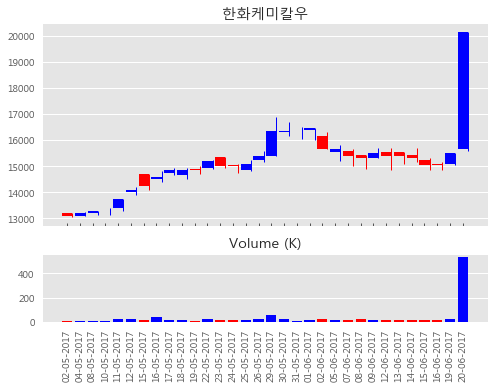


###  한화케미칼우 : 종목뉴스(최신) ###
1 한화, 서비스업종 1,000명 정규직 전환
2 [fnRASSI]장마감, 거래소 상승 종목(한화케미칼우...
3 한화케미칼, 실적 전망에 대한 기대감에 상승
4 한화케미칼, 한화증권에 200억원 무보증사채 매도 결정
5 한화건설, 임직원 승진 시 1개월 유급휴가 지원
6 장 마감 후 공시 [4월7일]
7 [오늘의 종목]한화케미칼, 부진한 태양광 화학으로 뒷받...
8 한화케미칼, 사상 최대 실적 기대감에 강세
9 엔씨소프트, 리니지 등 게임 흥행에 3분기 호실적 달성
10 파리기후협약 발효에 신재생에너지주 강세


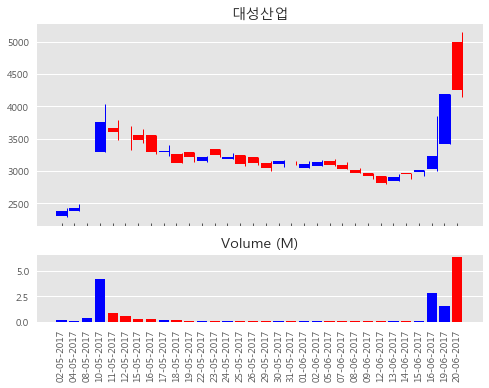


###  대성산업 : 종목뉴스(최신) ###
1 [터치!Peak&Bottom]대성산업·대성합동지주, 합...
2 [fnRASSI]장마감, 거래소 상승 종목(대성산업 2...
3 [특징주]합병 기대 재부각…대성산업·대성합동지주 동반 ...
4 [Hot-Line] 대성산업·대성합동지주, 합병 기대감...
5 대성산업, 발행주식 83% 소각한다
6 미래에셋대우-우리銀, 모던하우스 M&A에 3천억 댄다
7 [e공시 눈에 띄네]코스피-17일
8 [유가증권 기업공시] (17일) 대성산업 등
9 대성산업 "거제백화점 매각 추진 보류"
10 대성산업, 디큐브거제백화점 매각추진 보류


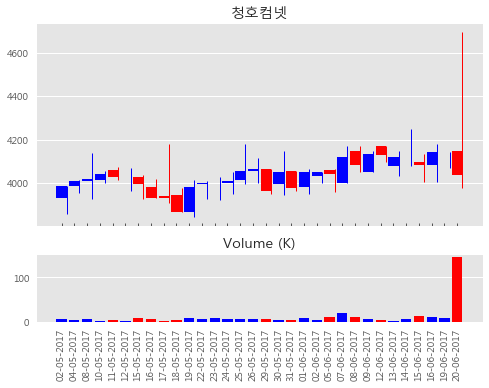


###  청호컴넷 : 종목뉴스(최신) ###
1 청호컴넷, 이매진아시아 지분율 41.61%…20.16%...
2 청호컴넷, 세원 보유 주식 16만주 이매진아시아에 20...
3 [fnRASSI]청호컴넷, 52주 신저가 기록...-2...
4 [fnRASSI]청호컴넷, 52주 신저가 경신...-3...
5 [fnRASSI]청호컴넷, 52주 신저가 기록...-2...
6 [fnRASSI]청호컴넷, 52주 신저가 기록...-2...
7 [fnRASSI]청호컴넷, 52주 신저가 경신...-2...
8 물렁한 규제 비웃는 허위공시
9 [fnRASSI]청호컴넷(012600), 52주 신저가...
10 [fnRASSI]청호컴넷(012600), 52주 신저가...


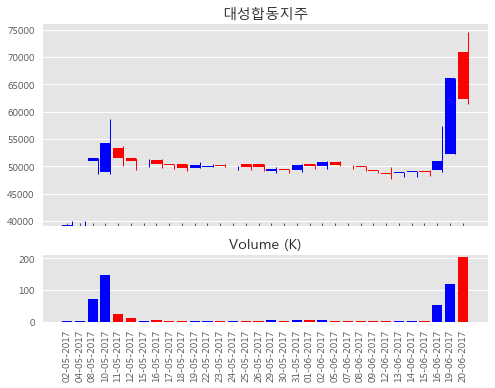


###  대성합동지주 : 종목뉴스(최신) ###
1 코스피, 외인 '사자' 상승... 삼성電·SK하이닉스 ...
2 [터치!Peak&Bottom]대성산업·대성합동지주, 합...
3 [시황종합]코스피, 외인 '사자' 2370선 턱걸이.....
4 [fnRASSI]장마감, 거래소 상승 종목(대성산업 2...
5 [Hot-Line] 대성산업·대성합동지주, 합병 기대감...
6 코스피, 외인·기관 '팔자' 보합... SK하이닉스 또...
7 대성산업, 발행주식 83% 소각한다
8 [장 마감 후 기업공시]5월 30일
9 대성합동지주, 자회사에 2400억원 규모 담보 제공
10 대성합동지주, 자회사에 2400억원 규모 담보 제공


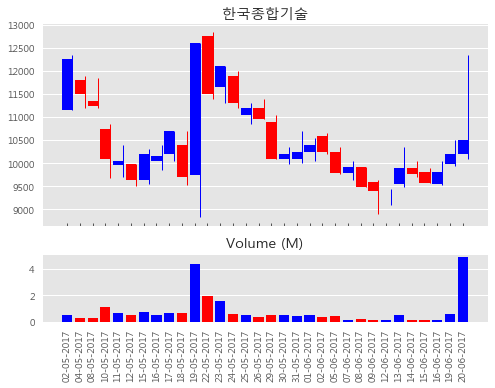


###  한국종합기술 : 종목뉴스(최신) ###
1 한국종합기술, 대규모 용역제공 계약 후 주가 상승
2 [장마감후 기업공시]6월 12일
3 한국종합기술, 인천국제공항과 125억규모 용역계약
4 한국종합기술, 인천국제공항공사와 125.6억 규모 용역...
5 한국종합기술, 인천국제공항공사와 126억 용역 계약
6 장 마감 후 주요 공시-1일
7 한국종합기술, 114억원 규모 '인천공항 4단계 에어사...
8 한국종합기술, 인천국제공항 설계 용역 낙찰
9 한국종합기술, 114억 규모 인천공항 설계용역 낙찰
10 한국종합기술 노조 "임직원과 합의 없는 일방적 매각 반...


In [58]:
# 상품별 차트
def url_elem(u):  # HTML -> text 
    url = u
    resp = requests.get(url)
    return html.fromstring(resp.text)
   
def charts_news(code, code_nm):
    # 캔들 + 거래량 차트
    df = web.DataReader(code, 'google', bef_50_dt, bef_dt)
    df.columns = ['open_price', 'high', 'low', 'close_price', 'volume']
    plot_candles(df, title=code_nm, volume_bars=True)  # 오픈소스 코드    
    plt.show()
 
    # 네이버 종목 뉴스
    elem = url_elem('http://finance.naver.com/item/news_news.nhn?code=' + code[4:] + '&page=')     
    n = []
    for i in elem.cssselect('td.title a'):
        n.append(i.text_content().strip())    
    print("")
    print('### ', code_nm, ': 종목뉴스(최신) ###')     
    for i, z in enumerate(n):
        print(str(i+1) + ' ' + z)
        
# charts_news('KRX:105840', '우진')

# TOP5개 종목
for i in range(5):
    charts_news(df_volume.ix[i,2], df_volume.ix[i,1])